In [1]:
%matplotlib inline
from matplotlib import image
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.ndimage as sn

In [2]:
image1 = plt.imread("church.JPG")

In [3]:
def enhancement(im,alpha = 1.1,gamma=5/255,delta=5/255,lambda_e=0.005,tol = 1e-5,maxiter=1000,S=[0,255]):
    a,b,channel = im.shape ##圖片大小
    ##用於差分
    imu = np.array([0]+[i for i in range(a-1)])
    imd = np.array([i+1 for i in range(a-1)]+[a-1])
    iml = np.array([0]+[i for i in range(b-1)])
    imr = np.array([i+1 for i in range(b-1)]+[b-1])
    Lambda = lambda_e/gamma
    Delta = delta/gamma;
    beta = 3*alpha
    ##3 channel
    rc,gc,bc = im[:,:,0],im[:,:,1],im[:,:,2]
    fmax = np.where(np.where(rc<gc, gc,rc)<bc , bc ,np.where(rc<gc,gc,rc))##a function
    fmax_bar = np.mean(fmax)
    omega_d = fmax<=fmax_bar ##暗部
    omega_b = fmax>fmax_bar ##亮部
    img=[]
    start = time.time()
    for k in range(channel):
        ##initial condition
        fk = im[:,:,k]
        uk = fk
        v = uk
        bx = np.zeros([a,b])
        by = np.zeros([a,b])
        dx = np.zeros([a,b])
        dy = np.zeros([a,b])
        c = np.zeros([a,b])
        ##gradient f
        fxd = np.concatenate((np.diff(fk,1,1), np.zeros([a,1])),axis=1);
        fyd = np.concatenate((np.diff(fk,1,0),np.zeros([1,b])));
        ##g function brighter
        fbar = np.mean(fk);
        g = omega_d*(alpha*fbar)+omega_b*fk
        
        ##h function control contrast-level
        ##convolutuion using gaussian filter to make h smooth
        sigma =4.6
        w = 2*sigma+1.0
        t = float((((w - 1)/2)-0.5)/5)
        h = sn.gaussian_filter((beta*omega_d + omega_b),sigma=sigma,mode ='constant',truncate=t) 
        ##to compute grad h
        fk = fk*h
        fx = np.concatenate((np.diff(fk,1,1), np.zeros([a,1])),axis=1);
        fy = np.concatenate((np.diff(fk,1,0),np.zeros([1,b])));
        fx[omega_b] = fxd[omega_b]
        fy[omega_b] = fyd[omega_b]

        it = 0;  #interative times
        error = 10000;  #relative error
        while it < maxiter and error >= tol :
            ##u-subproblem
            d_f_bx = dx+fx-bx;
            d_f_by = dy+fy-by;
            up = uk
            uk = (Lambda*g - d_f_bx - d_f_by \
                     +np.concatenate((np.zeros([a,1]),d_f_bx[:,0:b-1]),axis=1)\
                     +np.concatenate((np.zeros([1,b]),d_f_by[0:a-1,:])) +Delta*(v-c)\
                     + uk[imd,:] + uk[:,iml] + uk[:,imr]+uk[imu,:] + 4*uk) /(Lambda+Delta+8)

            ##d-subproblem
               
            ux = np.concatenate((np.diff(uk,1,1), np.zeros([a,1])),axis=1);
            uy = np.concatenate((np.diff(uk,1,0),np.zeros([1,b])));
            dx = ((ux - fx) + bx)*gamma/(gamma+1);
            dy = ((uy - fy) + by)*gamma/(gamma+1);
            
            ##v-subproblem
            v = uk+c
            v[v<S[0]] = S[0]
            v[v>S[1]] = S[1]
            
            ##updating b c
            bx = bx + (ux - fx) - dx;
            by = by + (uy - fy) - dy;   
            c  = c  + uk - v;
            
            #relative error
            error =np.sum((uk-up)*(uk-up))/np.sum(up*up)
            it = it + 1;
        print("Iteration%d complete!!"%(k+1))
        print("Iteration :",it)
        img.append(uk)
    end = time.time()
    print(round(end-start,1),"sec")
    return img

In [4]:
img = enhancement(image1/1.0)

Iteration1 complete!!
Iteration : 51
Iteration2 complete!!
Iteration : 50
Iteration3 complete!!
Iteration : 50
16.2 sec


In [5]:
new_image = np.dstack((img[0],img[1],img[2]))/255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


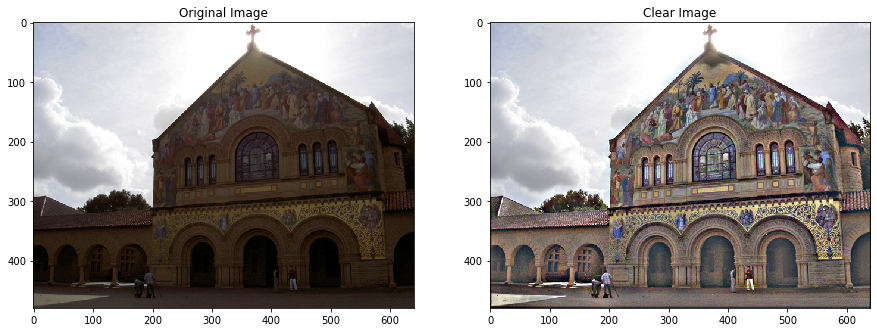

In [6]:
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(image1)
ax1.title.set_text("Original Image")
ax2.imshow(new_image)
ax2.title.set_text("Clear Image")